In [1]:
import ctranslate2
import transformers

translator = ctranslate2.Translator("madlad400-7b-mt-bt-ct2-int8_float16",device='cpu', compute_type="auto",  intra_threads=16)
tokenizer = transformers.AutoTokenizer.from_pretrained("jbochi/madlad400-7b-mt-bt")


In [2]:
print(ctranslate2.get_supported_compute_types('cpu'))
print('-'*4)
print(ctranslate2.get_supported_compute_types('cuda'))
print(translator.compute_type)

{'int8_float32', 'float32', 'int8'}
----
{'int8_float16', 'float32', 'int8', 'int8_float32', 'float16'}
int8_float32


In [3]:
#prefix = "<2en> "
#input_text_1 = "A diplomaterv célja földmegfigyelési szegmentációs és változásdetekciós algoritmusok fejlesztése. A szegmentáció és változásdetekció nagyon fontos részét képezik a földmegfigyelésnek, hiszen az egyik leggyakoribb kérdés a Földdel kapcsolatban, hogy hogyan változik. Az Európai Űrügynökség (ESA) missziói során folyamatosan, néhány naponta ismétlődve készít műholdképeket a Föld felszínéről, amelyek ingyenesen hozzáférhetőek. Ezeknek a képeknek a feldolgozása azonban új kihívásokat támaszt a jelenlegi módszerekkel szemben. A legnagyobb kihívás a mulitspektrális képek kezelése, illetve különböző adatforrások kombinálása. Erre a feladatra egy kiváló módszer a fúziós Markov Véletlen Mező módszer, amely nemcsak a különböző képtípusok fúzióját teszi lehetővé, de egy hatékony keretrendszert biztosít változásdetekcióra is."
#input_text_2 = 'A földmegfigyelésnek két egymástól nagymértékben különböző formája létezik.'
#input_tokens1  = tokenizer.convert_ids_to_tokens(tokenizer.encode(prefix + input_text_1))
#input_tokens2  = tokenizer.convert_ids_to_tokens(tokenizer.encode(prefix + input_text_2))
#print(len(input_tokens1),len(input_tokens2))
#
#results = translator.translate_batch([input_tokens1,input_tokens2])
#
#output_tokens = results[0].hypotheses[0]
#output_text = tokenizer.decode(tokenizer.convert_tokens_to_ids(output_tokens))
#print(output_text)
#
#output_tokens = results[1].hypotheses[0]
#output_text = tokenizer.decode(tokenizer.convert_tokens_to_ids(output_tokens))
#print(output_text)

In [23]:
def ct2_translate(text:str):
    prefix = "<2en> "
    input_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(prefix + text))
    try:
        results = translator.translate_batch([input_tokens])
    except Exception as e:
        return str(e)
    output_tokens = results[0].hypotheses[0]
    output_text = tokenizer.decode(tokenizer.convert_tokens_to_ids(output_tokens))
    return output_text

# Test speed on CPU

In [5]:
from tools import wc,sc,create_random_text,timing_decorator

In [6]:
t = create_random_text(20)
r = ct2_translate(t)

In [7]:
import pandas as pd
import random

random.seed("Howdy there!")

test_lengths = [5,10,15,30,60,90,120,150,300]
test_cases = [create_random_text(wc) for wc in test_lengths]

test = pd.DataFrame({"length":test_lengths,"text":test_cases})
test['actual_length'] = test['text'].apply(wc)

C:\Users\tomi\AppData\Local\Temp\ipykernel_24032\1049360705.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [9]:
@timing_decorator
def measure(text:str):
    return ct2_translate(text)
results = test['text'].progress_apply(measure)
res = pd.DataFrame(results.to_list(),columns=['ct2_time','ct2_result'])
test = pd.concat([test,res],axis=1)


  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
test_lengths = [350,550,650,400,500]
test_cases = [create_random_text(wc) for wc in test_lengths]

test_ext = pd.DataFrame({"length":test_lengths,"text":test_cases})
test_ext['actual_length'] = test_ext['text'].apply(wc)

results = test_ext['text'].progress_apply(measure)
res = pd.DataFrame(results.to_list(),columns=['ct2_time','ct2_result'])
test_ext = pd.concat([test_ext,res],axis=1)
test = pd.concat([test,test_ext],axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

<Axes: xlabel='length', ylabel='ct2_time'>

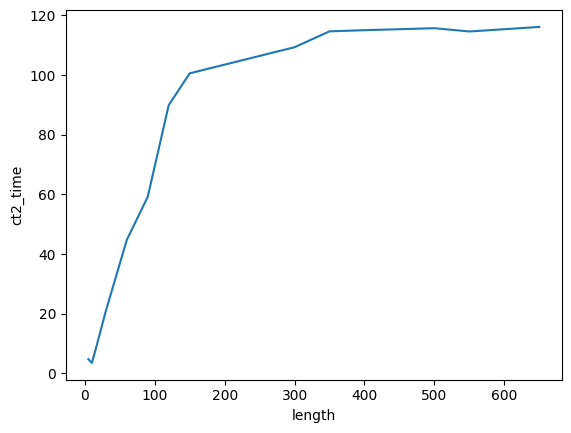

In [11]:
import seaborn as sns
sns.lineplot(test,x="length",y="ct2_time")

In [18]:
del translator

In [20]:
translator = ctranslate2.Translator("madlad400-7b-mt-bt-ct2-int8_float16",device='cuda', compute_type="int8_float16",  intra_threads=16)

In [21]:
t = create_random_text(20)
r = ct2_translate(t)

In [ ]:
results = test['text'].progress_apply(measure)
test['device'] = "cpu"
res = pd.DataFrame(results.to_list(),columns=['ct2_time','ct2_result'])
test_gpu = pd.concat([test[['length','text','actual_length']].reset_index(drop=True),res],axis=1)
test_gpu['device'] = 'gpu'
test_all = pd.concat([test.reset_index(),test_gpu])

<Axes: xlabel='length', ylabel='ct2_time'>

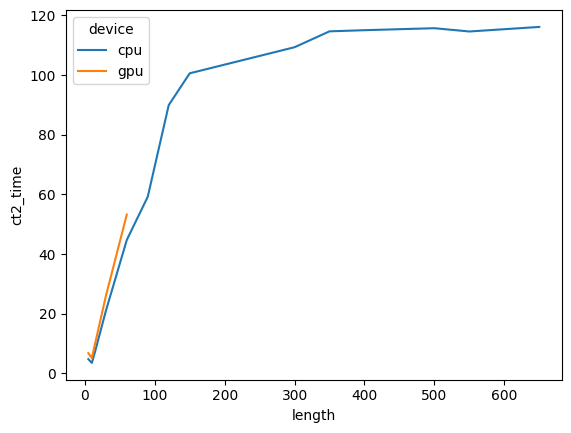

In [61]:
test_succes = test_all[test_all.ct2_result != 'CUDA failed with error out of memory']
sns.lineplot(test_succes,x="length",y="ct2_time",hue='device')

In [53]:
test_all['res_wc'] = test_all.ct2_result.apply(wc)
test_all.columns

Index(['index', 'length', 'text', 'actual_length', 'ct2_time', 'ct2_result',
       'device', 'res_wc'],
      dtype='object')

<Axes: xlabel='res_wc', ylabel='actual_length'>

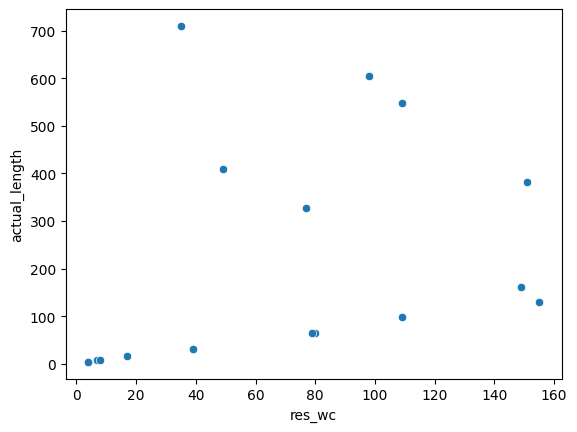

In [56]:
sns.scatterplot(test_succes,x='res_wc',y='actual_length')

In [59]:
def tc(s:str):
    input_tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(s))
    return len(input_tokens)

test_all['input_token_len'] = test_all.text.apply(tc)
test_all['res_token_len'] = test_all.ct2_result.apply(tc)

<Axes: xlabel='res_token_len', ylabel='input_token_len'>

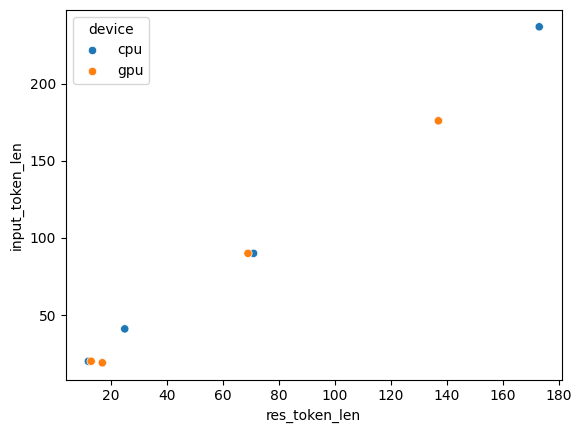

In [65]:
sns.scatterplot(test_succes[test_succes.input_token_len < 320],x='res_token_len',y='input_token_len',hue='device')